In [104]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
       

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautiful

In [105]:
# Import Dependencies
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [106]:
# Verifying correct data separation
os.listdir('chest_xray/train')
os.listdir('chest_xray/test')

['NORMAL', 'PNEUMONIA']

In [107]:
# Checking image size
img = cv2.imread(os.path.join('chest_xray', 'train', 'NORMAL', 'NORMAL-28501-0001.jpeg'))
img.shape

(2418, 2434, 3)

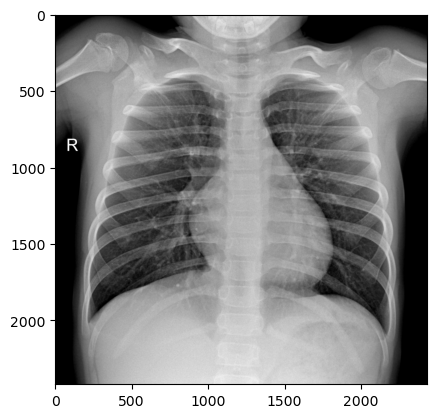

In [108]:
# Example image
plt.imshow(img)

In [87]:
# Dataset to train CNN
# train_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32, validation_split=0.3, subset="training", seed=42)
# validation_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32, validation_split=0.3, subset="validation", seed=42)
# Perform stratified split using scikit-learn

# data_dir = 'chest_xray/train'
# data = []
# labels = []
# for label in os.listdir(data_dir):
#     label_dir = os.path.join(data_dir, label)
#     for image_file in os.listdir(label_dir):
#         image_path = os.path.join(label_dir, image_file)
#         data.append(image_path)
#         labels.append(label)

# train_data, val_data, train_labels, val_labels = train_test_split(
#     data, labels, test_size=0.3, stratify=labels, random_state=42)

# train_data = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# val_data = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

# batch_size = 32
# train_data = train_data.shuffle(len(train_data)).batch(batch_size)
# val_data = val_data.batch(batch_size)


# test_data = tf.keras.utils.image_dataset_from_directory('chest_xray/test', batch_size=32)

Train Data Size: 115
Validation Data Size: 50
Found 624 files belonging to 2 classes.


In [112]:
data_dir= 'chest_xray/train'
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)      

In [129]:
import numpy as np

# data = tf.keras.utils.image_dataset_from_directory('chest_xray/train')

# train_data, val_data, train_labels, val_labels = train_test_split(
#     data, labels, test_size=0.3, stratify=labels, random_state=42)
# # 
# train_data = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# val_data = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

# batch_size = 32
# train_data = train_data.shuffle(len(train_data)).batch(batch_size)
# val_data = val_data.batch(batch_size)

data_iterator = data.as_numpy_iterator()

Found 5232 files belonging to 2 classes.


In [130]:
batch = data_iterator.next()

In [131]:
batch[0].shape

(32, 256, 256, 3)

In [119]:
batch[1]

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

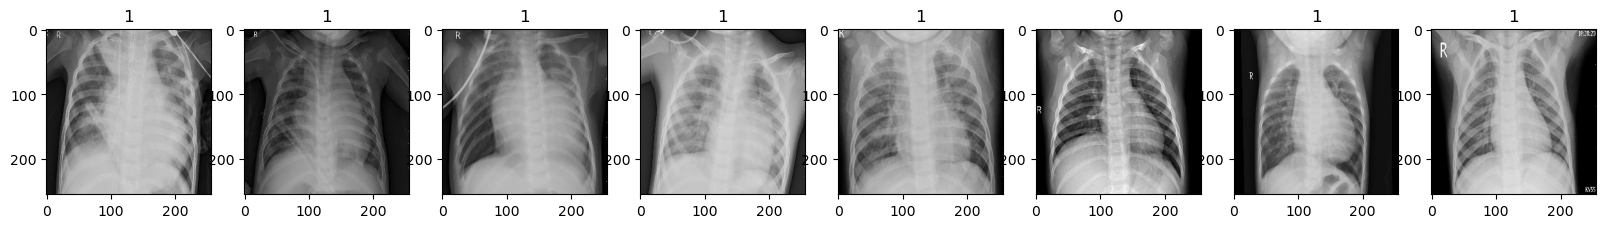

In [123]:
fig, ax = plt.subplots(ncols=8 ,figsize=(20, 20))
for i , img in enumerate(batch[0][:8]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])
    

### The "1" Classification indicates a pneumonia positive image ###

In [32]:
batch[0].min(), batch[0].max()

(0.0, 255.0)

In [33]:
scaled = batch[0] / 255

In [34]:
scaled.min(), scaled.max()

(0.0, 1.0)

# PreProcessing

In [132]:
preprocess_data = data.map(lambda x, y: (x/255, y))

In [133]:
preprocess_data.as_numpy_iterator().next()[0].max()

1.0

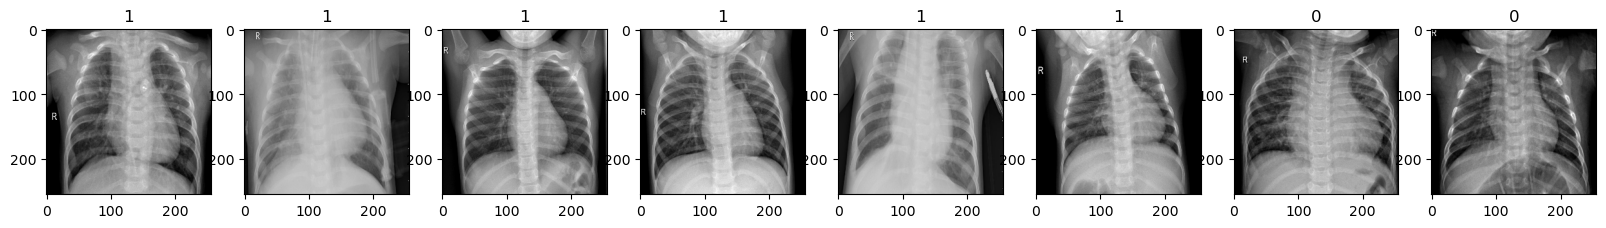

In [134]:
fig, ax = plt.subplots(ncols=8 ,figsize=(20, 20))
for i, img in enumerate(preprocess_data.as_numpy_iterator().next()[0][:8]):
    ax[i].imshow(img)
    ax[i].title.set_text(batch[1][i])

In [140]:
train_data = int(len(data) *.7)
val_data = int(len(data) *.3)
test_data = tf.keras.utils.image_dataset_from_directory('chest_xray/test', batch_size=32)

Found 624 files belonging to 2 classes.


In [144]:
train = data.take(train_data)
validate = data.skip(train_data).take(val_data)

### CNN Model Construction ###

In [141]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
# Convulational Layer #1
model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
# Convulational Layer #2
model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())
# Convulational Layer #3
model.add(Conv2D(16, (3,3),1, activation='relu'))
model.add(MaxPooling2D())
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




In [142]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 16)       

In [150]:
# Model Training
train_regime = model.fit(train, epochs=10, validation_data=validate)

Epoch 1/10


114/114 [==============================] - 21s 186ms/step - loss: 0.0269 - accuracy: 0.9904 - val_loss: 0.1532 - val_accuracy: 0.9636
Epoch 2/10
114/114 [==============================] - 22s 188ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.1491 - val_accuracy: 0.9656
Epoch 3/10
 14/114 [==>...........................] - ETA: 14s - loss: 0.0097 - accuracy: 0.9978

KeyboardInterrupt: 

In [147]:
train_regime.history

{'loss': [0.09831999987363815,
  0.0579511895775795,
  0.027419455349445343,
  0.015827830880880356,
  0.010826426558196545],
 'accuracy': [0.96875,
  0.9810855388641357,
  0.9923245906829834,
  0.9958881735801697,
  0.9969846606254578],
 'val_loss': [0.14058931171894073,
  0.1375364065170288,
  0.1103978380560875,
  0.14056357741355896,
  0.15255051851272583],
 'val_accuracy': [0.9604591727256775,
  0.9604591727256775,
  0.96875,
  0.9655612111091614,
  0.9674744606018066]}

In [148]:
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


20/20 [==============================] - 1s 43ms/step - loss: 0.8141 - accuracy: 0.8542
Test Loss: 0.8140909671783447
Test Accuracy: 0.8541666865348816


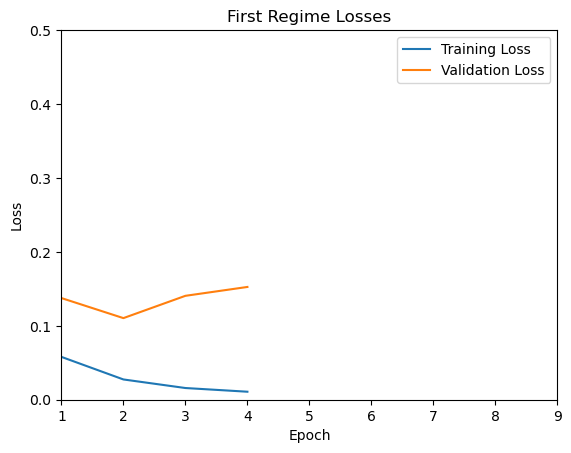

In [149]:
plt.plot(train_regime.history['loss'], label='Training Loss')
plt.plot(train_regime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,11))
plt.xlim(1,9)
plt.ylim(0,.5)
plt.title('First Regime Losses')
plt.legend()
plt.show()


In [24]:
plt.plot(first_regime.history['accuracy'], label='Training Accuracy')
plt.plot(first_regime.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 10))
plt.title('First Regime Accuracy')
plt.legend()
plt.show()


NameError: name 'first_regime' is not defined

Epoch 1/10


17/20 [========================>.....] - ETA: 0s - loss: 2.8472e-04 - accuracy: 1.0000

KeyboardInterrupt: 